In [2]:
import torch
import numpy as np
import sys, copy, math, time, pdb
import os.path
import random
import pdb
import csv
import argparse
import itertools
from itertools import permutations, product
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torchdiffeq import odeint
import itertools
import matplotlib.pyplot as plt
import tqdm as tqdm
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial.distance import braycurtis
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from collections import defaultdict

In [2]:
def get_batch(ztrn,ptrn,mb_size):
    s = torch.from_numpy(np.random.choice(np.arange(ptrn.size(dim=0), dtype=np.int64), mb_size, replace=False))
    batch_p = ztrn[s,:]
    batch_q = ptrn[s,:]
    batch_t = t[:batch_time]
    return batch_p.to(device), batch_q.to(device)


def loss_bc(p_i,q_i):
    return torch.sum(torch.abs(p_i-q_i))/torch.sum(torch.abs(p_i+q_i))

def process_data(P):
    #Z = P.copy()
    #Z[Z!=0] = 1
    P = P/P.sum(axis=0)[np.newaxis,:]
    #Z = Z/Z.sum(axis=0)[np.newaxis,:]
    
    P = P.astype(np.float32)
    #Z = Z.astype(np.float32)

    P = torch.from_numpy(P.T)
    #Z = torch.from_numpy(Z.T)
    return P


class ODEFunc(torch.nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.fcc1 = torch.nn.Linear(N, N)
        self.fcc2 = torch.nn.Linear(N, N)

    def forward(self, y):
        out = self.fcc1(y)
        out = self.fcc2(out)
        return torch.mul(y,torch.abs(out))/torch.sum(torch.mul(y,torch.abs(out)))


def train_reptile(max_epochs,mb,LR,ztrn,ptrn,ztst,ptst,zval,pval,zall,pall):
    loss_train = []
    loss_val = []
    qtst = np.zeros((ztst.size(dim=0),N))
    qtrn = np.zeros((zall.size(dim=0),N))
    ltst_pred = np.zeros((ztst.size(dim=0),1))
    ltst_ground = np.zeros((ztst.size(dim=0),1))
    
    func = ODEFunc().to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=LR)

    Loss_opt = 1
    for e in range(max_epochs):
        optimizer.zero_grad()
        batch_p, batch_q = get_batch(ztrn,ptrn,mb)
        
        # loss of the traning set
        for i in range(mb):
            p_pred = func(batch_p[i]).to(device)
            p_pred = torch.reshape(p_pred,(1,N))
            if i==0:
                loss = loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
            else:
                loss = loss + loss_bc(p_pred.unsqueeze(dim=0),batch_q[i].unsqueeze(dim=0))
        loss_train.append(loss.item()/mb)


        # validation set
        for i in range(zval.size(dim=0)):
            p_pred = func(zval[i]).to(device)
            p_pred = torch.reshape(p_pred,(1,N))
            if i==0:
                l_val = loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
            else:
                l_val = l_val + loss_bc(p_pred.unsqueeze(dim=0),pval[i].unsqueeze(dim=0))
        loss_val.append(l_val.item()/zval.size(dim=0))
        if l_val.item()/zval.size(dim=0)<=Loss_opt:
            Loss_opt = loss_val[-1]
            best_model = copy.deepcopy(func)
        #print('epoch = ',e, 'loss = ', l_val.item()/mb)

        # update the neural network
        func.zero_grad()
        loss.backward()
        optimizer.step()

        if e == max_epochs-1:
            func = copy.deepcopy(best_model)
            if len(ztst.size())==2:
                for i in range(ztst.size(dim=0)):
                    pred_test = func(ztst[i]).to(device)
                    pred_test = torch.reshape(pred_test,(1,N))
                    qtst[i,:] = pred_test.detach().numpy()
                for i in range(zall.size(dim=0)):
                    pred_test = func(zall[i]).to(device)
                    pred_test = torch.reshape(pred_test,(1,N))
                    qtrn[i,:] = pred_test.detach().numpy()
    return loss_train,qtst,qtrn

In [4]:
# hyperparameters
max_epochs = 5000
device = 'cpu'
batch_time = 100
t = torch.arange(0.0, 100.0, 0.01)


# load the dataset
filepath_train = f'./data/Ptrain.csv' #this is the simulated data using ER network 
P = np.loadtxt(filepath_train,delimiter=',')

Z = P.copy()
Z[Z!=0] = 1

pall = process_data((P))
zall = process_data(Z)

number_of_cols = P.shape[1]
random_indices = np.random.choice(number_of_cols, size=int(0.2*number_of_cols), replace=False)
P_test = P[:,random_indices]
Z_test = Z[:,random_indices]
P_train =  P[:,np.setdiff1d(range(0,number_of_cols),random_indices)]
Z_train =  Z[:,np.setdiff1d(range(0,number_of_cols),random_indices)]

number_of_cols = P_train.shape[1]
random_indices = np.random.choice(number_of_cols, size=int(0.2*number_of_cols), replace=False)
P_val= P_train[:,random_indices]
Z_val = Z_train[:,random_indices]
P_train =  P_train[:,np.setdiff1d(range(0,number_of_cols),random_indices)]
Z_train =  Z_train[:,np.setdiff1d(range(0,number_of_cols),random_indices)]

ptrn= process_data((P_train))
pval = process_data((P_val))
ztrn = process_data(Z_train)
zval = process_data(Z_val)

ptst = process_data((P_test))
ztst = process_data(Z_test)

M, N = ptrn.shape

# pre training to select the parameter
LR = 0.01
mb = 20

loss_train,qtst,qtrn = train_reptile(max_epochs,mb,LR,ztrn,ptrn,ztst,ptst,zval,pval,zall,pall)
print(zall.shape)
print(qtst.shape)
print(ptst.shape)
np.savetxt(f'./results/mapping_prediction.csv',qtst,delimiter=',')
np.savetxt(f'./results/mapping_true.csv',ptst,delimiter=',')

torch.Size([500, 100])
(100, 100)
torch.Size([100, 100])


In [4]:
#Visual lize
def format_p_value(p):
    if p < 1e-4:
        return f'p < 1e-4'
    else:
        return f'p = {p:.1e}'

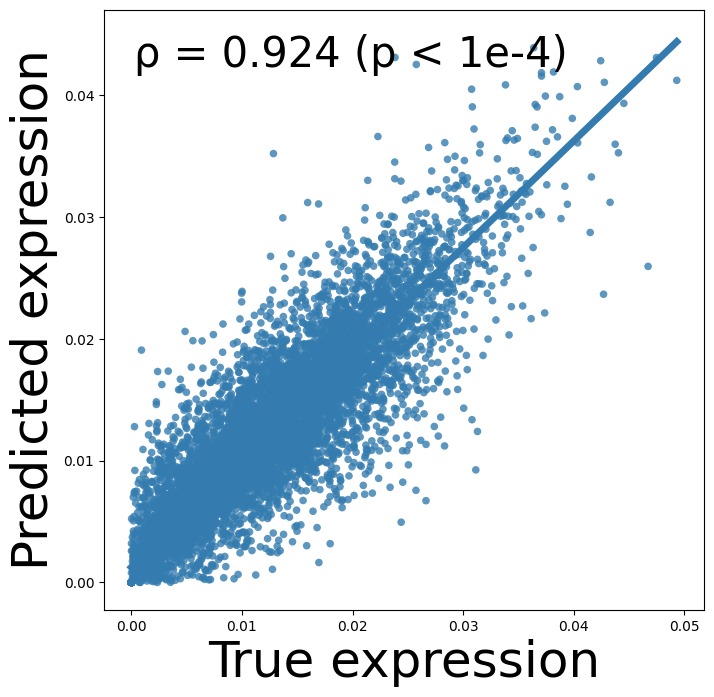

In [5]:
pred_profile = pd.read_csv(f'./results/mapping_prediction.csv',header =None).values.astype(float)#cells×genes(100×100)
true_profile = pd.read_csv(f'./results/mapping_true.csv',header =None).values.astype(float)#cells×genes(100×100)
true_filtered = true_profile.flatten()
pred_filtered = pred_profile.flatten()

true_filtered = true_filtered
pred_filtered = pred_filtered

pearson_r, pearson_p = stats.pearsonr(true_filtered, pred_filtered)
spearman_r, spearman_p = stats.spearmanr(true_filtered, pred_filtered)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])  # [left, bottom, width, height]

# 散点图
ax.scatter(true_filtered, pred_filtered, alpha=0.8, s=30, color='#347CAF',edgecolor='none')


sns.regplot(x=true_filtered,
            y=pred_filtered,
            scatter = False,
            line_kws = {'color':'#347CAF','linewidth':5},
            ci = 95,
            ax=ax
)
stats_text = (
#     f'r = {pearson_r:.3f} ({format_p_value(pearson_p)})\n'
    f'ρ = {spearman_r:.3f} ({format_p_value(spearman_p)})'
)
ax.text(0.05, 0.96, stats_text, transform=ax.transAxes,
        ha='left', va='top', fontsize=30)

# ticks = np.arange(0, 0.08, 0.02)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)

ax.set_xlabel('True expression', fontsize=36)
ax.set_ylabel('Predicted expression', fontsize=36)

plt.show()